In [3]:
import numpy as np
import pandas as pd

## Model

In [4]:
# Let's build the simplest possible autoencoder
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# Configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


# Create a separate encoder model:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)


# Create a separate decoder model:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Data

In [16]:
# Data
# Let's prepare our input data. We're using MNIST digits, and we're discarding the labels 
# (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Training

Now let's train our autoencoder for 50 epochs:

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1042 - val_loss: 0.1023
Epoch 2/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1039 - val_loss: 0.1020
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1036 - val_loss: 0.1017
Epoch 4/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1033 - val_loss: 0.1014
Epoch 5/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1030 - val_loss: 0.1012
Epoch 6/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1027 - val_loss: 0.1009
Epoch 7/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1025 - val_loss: 0.1007
Epoch 8/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1022 - val_loss: 0.1004
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1020 - val_loss: 0.1002
Epoch

## Visualize what the autoencoder do

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

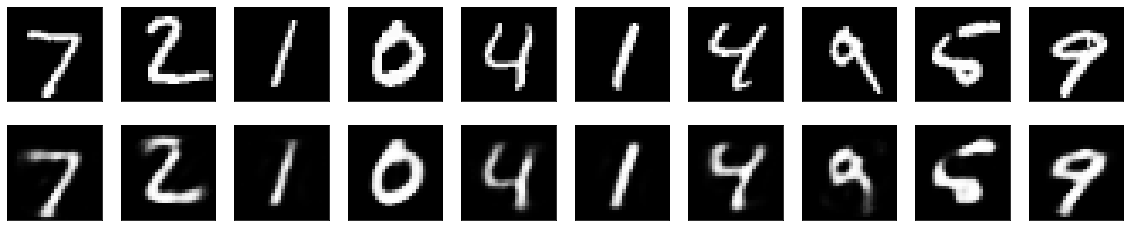

In [13]:
# use Matplotlib (don't ask)
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.6732 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4531 - val_loss: 0.4

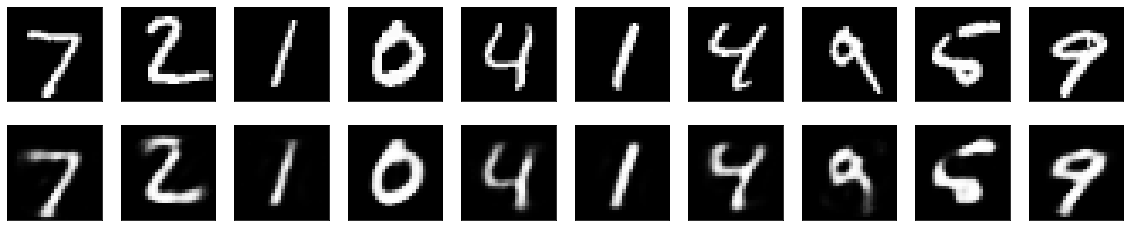

In [18]:
# New version of model
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Training
# Let's train this model for 100 epochs (with the added regularization the model is 
# less likely to overfit and can be trained longer). The models ends with a train 
# loss of 0.11 and test loss of 0.10. The difference between the two is mostly due 
# to the regularization term being added to the loss during training (worth about 0.01).
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


# Show the results
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()